Finally something that would be interesting to check is local adaptation related to changes in climate
so somehow relate the changes in allele frequency at one location with changes in climate at that location, since the other analysis are only accounting for global adaptation 

In [1]:
import allel
import pandas as pd
import numpy as np
import seaborn as sns

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
## lets get the pairs 

In [3]:
pairs = pd.read_csv('historical_and_modern_pairs.csv')

In [4]:
all_pairs = pd.concat([pairs['historical_id'], pairs['modern_id'].astype(str)])

In [5]:
## all teh samples

In [6]:
meta = pd.read_csv("all_valid_accessions_meta.csv")

In [7]:
meta = meta[meta['accession'].isin(all_pairs)]

In [8]:
# Calculate the bounds of the sample points
minx, miny, maxx, maxy = gdf.total_bounds

# Add some padding (degrees)
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1

# Set axis limits to zoom
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)



NameError: name 'gdf' is not defined

/tmp/ipykernel_913304/378745759.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


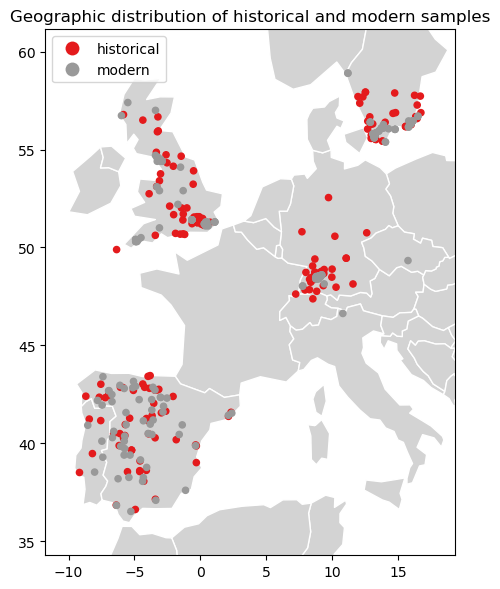

In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

meta = meta.dropna(subset=['lat', 'lon'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta['lon'], meta['lat']), crs='EPSG:4326')

# Load basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.plot(ax=ax, column='type', markersize=20, legend=True, cmap='Set1')

# Zoom into where samples are
minx, miny, maxx, maxy = gdf.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

plt.title("Geographic distribution of historical and modern samples")
plt.tight_layout()
plt.show()


In [ ]:
## there seems to be 3 distinct clusters 

In [9]:
def assign_cluster_by_country(row):
    if row['country'] in ['ESP', 'POR']:
        return 'Iberia'
    elif row['country'] == 'SWE':
        return 'Scandinavia'
    elif row['country'] == 'UK':
        return 'UK'
    else:
        return 'CentralEurope'  # FRA, GER, SUI, CZE, ITA

meta['cluster'] = meta.apply(assign_cluster_by_country, axis=1)


/tmp/ipykernel_913304/4073716875.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


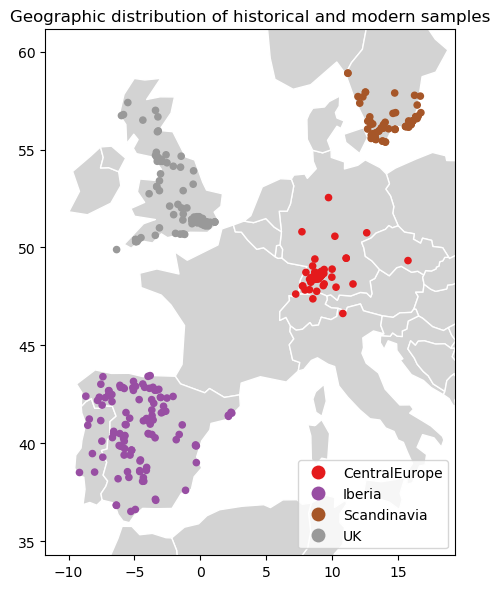

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

meta = meta.dropna(subset=['lat', 'lon'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta['lon'], meta['lat']), crs='EPSG:4326')

# Load basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.plot(ax=ax, column='cluster', markersize=20, legend=True, cmap='Set1')

# Zoom into where samples are
minx, miny, maxx, maxy = gdf.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

plt.title("Geographic distribution of historical and modern samples")
plt.tight_layout()
plt.show()


In [ ]:
## we are gonna start analysis each of teh different clusters now 
## lets start with iberia 

In [81]:
meta.to_csv('meta_filtered_clusters.csv',index=None)

In [10]:
meta_iberia = meta[meta['cluster'].isin(['Iberia'])]

In [11]:
meta_iberia.groupby('type')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
historical,56.0,1980.875,12.126699,1942.0,1976.5,1983.5,1988.25,2000.0
modern,56.0,2002.500,2.802596,1999.0,1999.0,2004.0,2005.00,2007.0


In [12]:
ids_hist = meta_iberia[meta_iberia['type'] == 'historical']['accession'].to_list()

In [13]:
ids_modern = meta_iberia[meta_iberia['type'] == 'modern']['accession'].to_list()

In [49]:
historical = allel.read_vcf('hist_shared_paired_samples_filtered_biallelic.vcf.gz',
                            samples = ids_hist)

In [53]:
modern = allel.read_vcf('modern_shared_paired_samples_filtered_biallelic.vcf.gz',
                       samples = ids_modern)

In [54]:
gt_historical = allel.GenotypeArray(historical['calldata/GT'])

In [55]:
gt_modern = allel.GenotypeArray(modern['calldata/GT'])

In [56]:
# Concatenate across samples
gt_combined = allel.GenotypeArray(
    np.concatenate([gt_historical, gt_modern], axis=1)
)

In [57]:
n_hist = gt_historical.shape[1]
n_mod = gt_modern.shape[1]

subpops = [list(range(n_hist)), list(range(n_hist, n_hist + n_mod))]

In [58]:
subpops = {
    'historical': list(range(n_hist)),
    'modern': list(range(n_hist, n_hist + n_mod))
}

In [59]:
gt_combined.shape

(1448536, 112, 2)

In [60]:
ac_combined = gt_combined.count_alleles()

In [61]:
maf = ac_combined.to_frequencies()

In [62]:
maf_filter_2d = (maf > 0.05) & (maf < 0.95)  # remove low and fixed variants

In [63]:
maf_mask = maf_filter_2d.any(axis=1)

In [64]:
gn = gt_combined.to_n_alt()  # shape: (variants, samples)


In [65]:
gn_filt = gn[maf_mask, :]

In [66]:
loc_unlinked = allel.locate_unlinked(gn_filt, size=100, step=20, threshold=0.8)

In [67]:
# Final mask
final_mask = maf_mask.copy()
final_mask[maf_mask] = loc_unlinked  # apply LD mask only where MAF passed

In [68]:
gt_final = gt_combined[final_mask, :]
positions_final = historical['variants/POS'][final_mask]
chroms_final = historical['variants/CHROM'][final_mask]

In [69]:
gt_final.shape

(255759, 112, 2)

In [73]:
len(subpops['historical'])

56

In [74]:
len(subpops['modern'])

56

In [75]:
# Example: historical = first 189 samples, modern = rest
gt_hist = gt_final[:, :len(subpops['historical'])]
gt_mod = gt_final[:, len(subpops['modern']):]

# Convert to allele counts
ac_hist = gt_hist.count_alleles()
ac_mod = gt_mod.count_alleles()

# Alt allele freq (assume biallelic)
af_hist = ac_hist.to_frequencies()[:, 1]
af_mod = ac_mod.to_frequencies()[:, 1]

# Delta AF
delta_af = af_mod - af_hist
abs_delta_af = np.abs(delta_af)


In [76]:
abs_delta_af

array([0.04571429, 0.0157563 , 0.04807692, ..., 0.09967532, 0.02668845,
       0.07142857])

In [77]:
# Wrap into a dataframe
df = pd.DataFrame({
    'chrom': chroms_final,
    'pos': positions_final,
    'delta_af': abs_delta_af
})

In [78]:
df

,chrom,pos,delta_af
0,1,346,0.045714
1,1,395,0.015756
2,1,540,0.048077
3,1,730,0.045105
4,1,755,0.024725
...,...,...,...
255754,5,26789461,0.093266
255755,5,26789499,0.068148
255756,5,26789553,0.099675
255757,5,26790408,0.026688
